如果说卷积神经网络可以有效地处理空间信息，那么本章的循环神经网络（recurrent neural network，
RNN）则可以更好地处理序列信息。

# **序列模型**

一些序列数据的例子

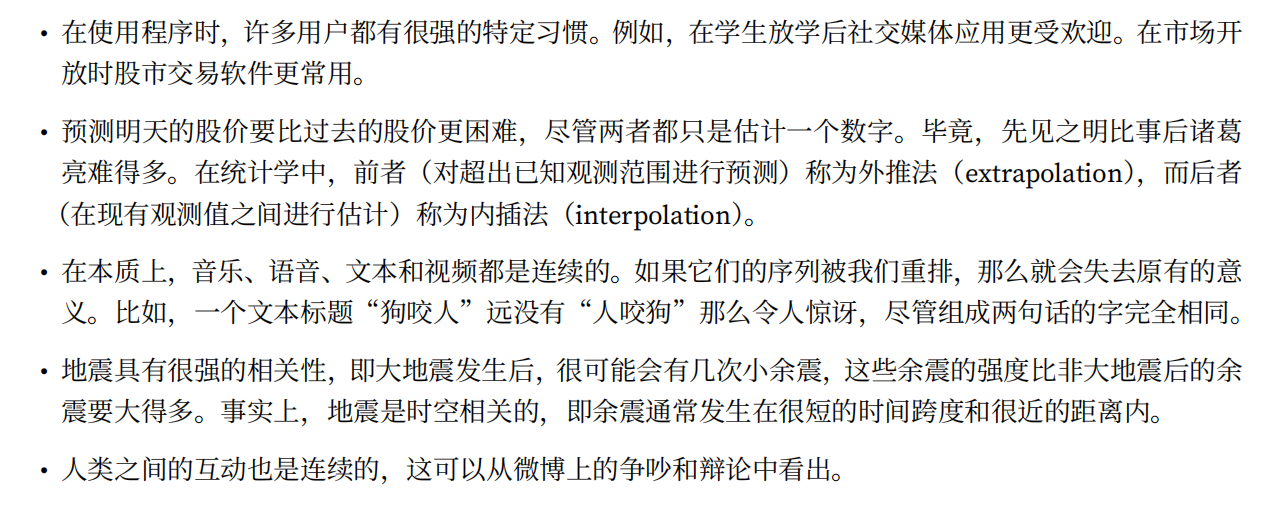

## 统计工具


以股票价格为例
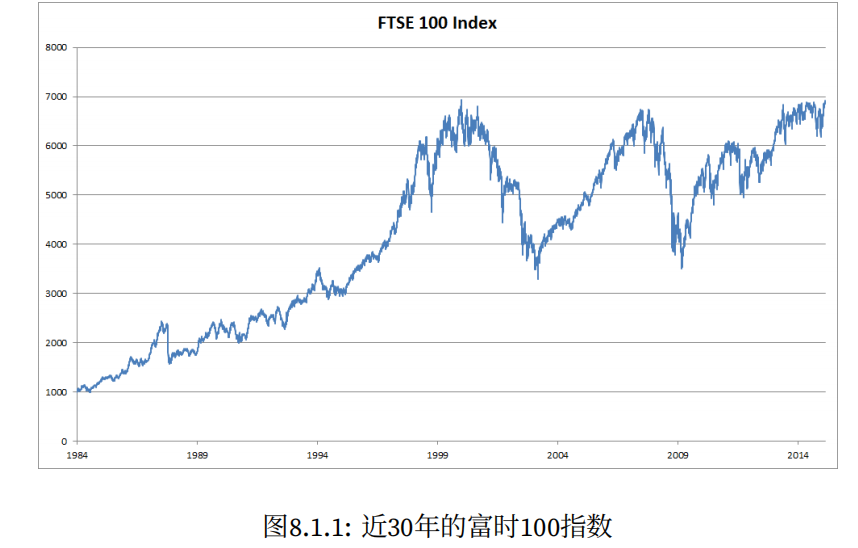

其中，用 $x_t$ 表示价格，即在时间步（time step） $t \in \mathbb{Z}^{+}$ 时，观察到的价格 $x_t$ 。请注意，$t$ 对于文本中的序列通常是离散的，并在整数或其子集上变化。假设一个交易员想在 $t$ 日的股市中表现良好，于是通过以下途径预测 $x_t$:
$$
    x_t \sim P(x_t | x_{t-1}, \cdots, x_1)
$$

### 自回归模型
由于输入数据的数量，输入 $x_{t-1}, \cdots, x_1$ 本身因 $t$ 而异。也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理。本章后面的大部分内容将围绕这如何有效估计 $P(x_t | x_{t-1}, \cdots, x_1)$ 展开。简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列 $x_{t-1}, \cdots, x_1$ 可能是不必要的，因此我们只需要满足某个长度为 $\tau$ 的时间跨度，即使用观测序列 $x_{t-1}, \cdots, x_{t - \tau}$ 。当下获得的最直接的好处就是参数的数量总是不变的，至少在 $t > \tau$ 时如此，这就使我们能够训练上面提及的深度网络。这种模型称为自回归模型，因为它们总是对自己执行回归。

第二种策略，如图所示

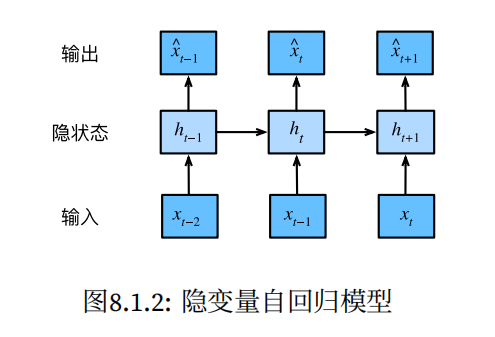

保留一些对过去观测的总结 $h_t$ ，并且同时更新预测 $\hat{x}_t$ 和总结 $h_t$ 。这就产生了基于 $\hat{x}_t = P(x_t | h_t)$ 估计 $x_t$ ，以及公式 $h_t = g(h_{t - 1}, x_{t - 1})$ 更新的模型。由于 $h_t$ 从未观测到，这类模型也被称为隐变量自回归模型。

这两种情况都有一个显而易见的问题：如何生成训练数据？

一种经典方法是使用历史观测来预测下一个未来观测。显然，我们并不指望时间会停滞不前。然而，一个常见的假设是虽然特定值 $x_t$ 可能会改变，但是序列本身的动力学不会改变。这样的假设是合理的，因为新的动力学一定受新的数据影响，而我们不可能用目前所掌握的数据来预测新的动力学。统计学家称不变的动力学为静止的。因此，整个序列的估计值都将通过一下的方式获得：
$$
    P(x_1, \cdots, x_T) = \prod_{t = 1}^{T} P(x_t | x_{t-1}, \cdots, x_1)
$$
注意，如果我们处理的是离散的对象（如单词），而不是连续的数字，则上述的考虑仍然有效。唯一的差别是，对于离散的对象，我们需要使用分类器而不是回归模型来估计 $P(x_t | x_{t-1}, \cdots, x_1)$。

### 马尔可夫模型


在自回归模型的近似法中, 我们使用 $x_{t-1}, \cdots, x_{t - \tau}$ 而不是 $x_{t-1}, \cdots, x_1$ 来估计 $x_t$ 。只要这种是近似精确的，我们就说序列满足马尔可夫条件。特别是，如果 $\tau = 1$ ，就得到一个一阶马尔可夫模型，$P(x)$ 由下式给出：
$$
    P(x_1, \cdots, x_T) = \prod_{t = 1}^{T} P(x_t | x_{t-1}) 当P(x_1 | x_0) = P(x_1).
$$ 


当假设 $x_t$ 仅是离散值时，这样的模型特别棒，因为在这种情况下，使用动态规划就可以沿着马尔可夫链精确地计算出结果。例如，我们可以高效地计算 $P(x_{t+1} | x_{t-1})$:
$$
    \begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：$P(x_{t+1} | x_t, x_{t-1}) = P(x_{t+1} | x_t)$。隐马尔可夫模型中的动态规划超出了本节的范围，而动态规划这些计算工具已经在控制算法个 强化学习算法广泛使用。

### 因果关系

原则上，将 $P(x_1, \cdots, x_T)$ 倒序展开也没什么问题。毕竟基于条件概率公式，我们总可以写出：
$$
    P(x_1, \cdots, x_T) = \prod_{t = T}^{1}P(x_t | x_{t + 1}, \cdots, x_T).
$$


事实上，如果基于一个马尔可夫模型，我们还可以得到一个反向的条件概率分布。然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。很明显，未来的事件不能影响过去。因此，如果改变 $x_t$ ，可能会影响未来发生的事情 $x_{t+1}$ ，但是不能反过来。也就是说，如果我们改变 $x_t$，基于过去事件得到的分布不会改变。因此，解释 $P(x_{t + 1} | x_t)$ 应该比解释 $P(x_t | x_{t+1})$ 更容易。例如，在某些情况下，对于某些可加性噪声 $\epsilon$，显然我们可以找到 $x_{t+1}=f(x_t) + \epsilon$，反之则不行。

### 训练
使用正弦函数和一些可加性噪声来生成序列数据，时间步为 $1, 2, \cdots, 100$。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

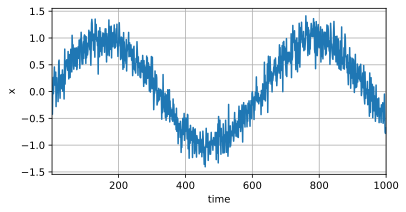

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的*特征-标签*对。基于 嵌入维度 $\tau$ ，我们 **[将数据映射为数据对 $y_t  = x_t$ 和 $\mathbf{x}_{t} = [x_{t-\tau}, \cdots, x_{t-1}]$]**。这比我们提供的数据样本少了 $\tau$ 个，因为我们没有足够的历史记录来描述前 $\tau$ 个数据样本。一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；另一个办法是用零来填充序列，在这里，我们仅使用前600个"特征-标签"对进行训练。

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里使用一个相对简单的架构训练模型，一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if  type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

准备训练模型，与前面的训练代码的方式基本相同

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.067542
epoch 2, loss: 0.050681
epoch 3, loss: 0.049259
epoch 4, loss: 0.048216
epoch 5, loss: 0.047563


预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。首先是检验模型的预测下一个时间步的能力，也就是单步预测

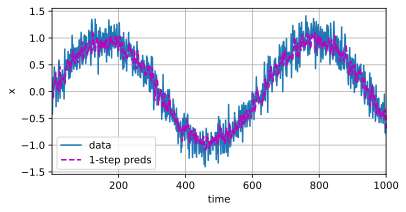

In [9]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

使用自己的预测（而不是原始数据）来进行多步预测

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1))
    )

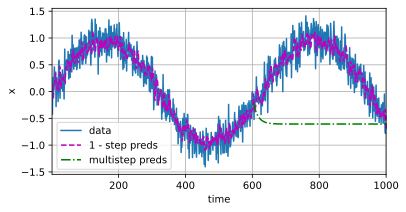

In [11]:
d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time',
    'x', legend=['data', '1 - step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3)
)

基于 $k = 1, 4, 16, 64$ ，通过对整个序列预测的计算，让我们更仔细地看一下 $k$ 步预测的困难。

In [12]:
max_steps = 64

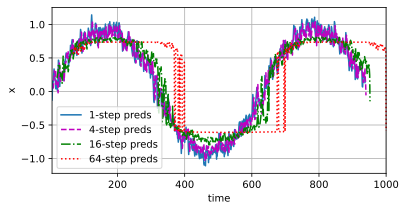

In [13]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从(i) 到 （i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自(i - tau + 1)步的预测，其时间步是从(i) 到 (i+T-tau-max_steps+1)
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot(
    [time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
    legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
    figsize=(6, 3)
)